In [2]:
import numpy as np
from scipy.linalg import qr
from scipy.linalg import svdvals
from scipy.linalg import pinv
from scipy.linalg.interpolative import interp_decomp
from matplotlib import pyplot as plt
import scipy.linalg.interpolative as sli
import scipy
import scipy.linalg 
import math
plt.rcParams['figure.figsize'] = [10, 8]

%matplotlib inline

In [3]:
import numpy as np
n = 1000
x = np.linspace(-1, 1, n)
eps = 0.1

def fun(x, y):
    """Evaluate a kernel function on a tensor grid"""
    xx = x.reshape(n,1)
    yy = y.reshape(1,n)
    return 1./(eps + np.abs(xx-yy))

A = fun(x, x)
nboxes = 20

In [4]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [5]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    size = n // nboxes 
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = get_box(0,i,A,nboxes,n).transpose()
    for j in range(1,nboxes):
        CCC = get_box(j,i,A,nboxes,n).transpose()
        CC = np.hstack((CC, CCC))  
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [6]:
def L(i,k,A,nboxes,n):
    import scipy.linalg.interpolative as sli
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    P1 = sli.reconstruct_interp_matrix(idx1,proj1)

    B1_trans = np.transpose(B1)
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    B2_trans = sli.reconstruct_skel_matrix(B1_trans,k,idx2)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    B2 = np.transpose(B2_trans)
    P2 = np.transpose(P2_trans)
    return P2

In [7]:
def S(i,j,k,A,nboxes,n):
    import scipy.linalg.interpolative as sli
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    
    idx11,proj11 = sli.interp_decomp(get_con_box(j,A,nboxes,n), k, rand = False)
    B11 = sli.reconstruct_skel_matrix(get_con_box(j,A,nboxes,n),k,idx11)
    B11_trans = np.transpose(B11)
    idx22,proj22 = sli.interp_decomp(B11_trans, k, rand = False)

    Sij_ = get_box(i,j,A,nboxes,n)[idx2[0:k],:]
    Sij = Sij_[:,idx22[0:k]]
    return Sij

In [8]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n))
    return RR

In [9]:
def mat(k,A,nboxes,n):
    size = n // nboxes
    m = np.zeros(( (size + k)*nboxes , (size + k)*nboxes))
    for i in range (nboxes):
        m[i*size : (i + 1)*size, i*size : (i + 1)*size] = get_box(i,i,A,nboxes,n)
    for j in range (nboxes):
        m[ n + j*k : n + (j + 1)*k, n + j*k : n + (j + 1)*k] = -np.identity(k)
    for r in range(nboxes):
        m[n + r*k : n + (r + 1)*k, r*size : (r + 1)*size] = R(r,k,A,nboxes,n)
    for s in range(nboxes):
        for t in range(nboxes):
            if s != t:
                m[s*size : (s + 1)*size, n + t*k : n + (t + 1)*k] = L(s,k,A,nboxes,n)@S(s,t,k,A,nboxes,n)
    return m          

In [10]:
size = n // nboxes

In [12]:
mat_D = np.zeros((n,n))
for i in range (nboxes):
    mat_D[i*size : (i + 1)*size, i*size : (i + 1)*size] = get_box(i,i,A,nboxes,n)

In [16]:
def mat_L(k,A,nboxes,n): 
    matrix_= np.zeros((n, k*nboxes))
    for i in range(nboxes):
        matrix_[i*size : (i + 1)*size, i*k : (i + 1)*k] = L(i,k,A,nboxes,n)
    return matrix_

In [17]:
def mat_S(k,A,nboxes,n): 
    matrix_= np.zeros((k*nboxes, k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                matrix_[i*k : (i + 1)*k, j*k : (j + 1)*k] = S(i,j,k,A,nboxes,n)
    return matrix_

In [25]:
def mat_R(k,A,nboxes,n): 
    matrix_= np.zeros((k*nboxes, n))
    for i in range(nboxes):
        matrix_[i*k : (i + 1)*k, i*size : (i + 1)*size] = R(i,k,A,nboxes,n)
    return matrix_

In [52]:
def mat1(k,A,nboxes,n):
    matrix_ = np.block([
        [mat_D,np.dot(mat_L(k,A,nboxes,n),mat_S(k,A,nboxes,n))],
        [mat_R(k,A,nboxes,n), -np.identity(k*nboxes)]
    ])
    return matrix_

In [69]:
def mat2(k,A,nboxes,n):
    matrix_ = np.block([
        [mat_D,                mat_L(k,A,nboxes,n),             np.zeros((n,k*nboxes))],
        [mat_R(k,A,nboxes,n),  np.zeros((k*nboxes,k*nboxes)),     -np.identity(k*nboxes)],
        [np.zeros((k*nboxes,n)), -np.identity(k*nboxes), mat_S(k,A,nboxes,n) ]
    ])
    return matrix_

In [77]:
import scipy
import scipy.linalg 
_,L1,U1 = scipy.linalg.lu(A)

In [78]:
det1 = 0
for i in range(n):
    det1 += math.log(U1[i,i])

In [79]:
det1

-943.2573345400157

In [54]:
def det_mat1(k,A,nboxes,n):
    _,L2,U2 = scipy.linalg.lu(mat1(k,A,nboxes,n))
    det2 = 0
    for i in range(n+k*nboxes):
        det2 +=math.log(abs(U2[i,i])) 
    return det2

In [70]:
def det_mat2(k,A,nboxes,n):
    _,L2,U2 = scipy.linalg.lu(mat2(k,A,nboxes,n))
    det2 = 0
    for i in range(n+2*k*nboxes):
        det2 +=math.log(abs(U2[i,i])) 
    return det2

In [61]:
def det_mat(k,A,nboxes,n):
    _,L2,U2 = scipy.linalg.lu(mat(k,A,nboxes,n))
    det2 = 0
    for i in range(n+k*nboxes):
        det2 +=math.log(abs(U2[i,i])) 
    return det2

In [73]:
l_det_mat2 = []
for i in range(1,size+1):
    l_det_mat2.append(det_mat2(i,A,nboxes,n))

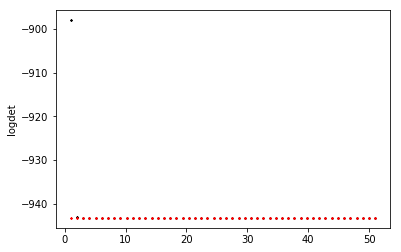

In [88]:
k_det = np.linspace(1,size+1,size)

l_det2 = []
for i in range(size):
    l_det2.append(det1)

plt.plot(k_det,l_det_mat2,'k*',markersize=2)
plt.plot(k_det,l_det2,'r*',markersize=2)

plt.ylabel('logdet') 
plt.show()

In [89]:
relative_error = []
for i in range(size):
    a = (l_det_mat2[i] - det1)/det1
    b = abs(a)
    if b == 0:
        relative_error.append(-16)
    else: 
        relative_error.append(np.log10(b))

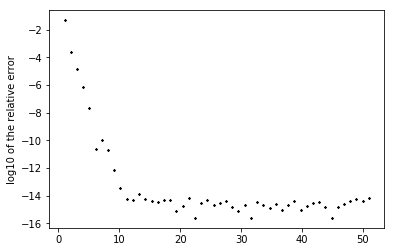

In [91]:
k_det = np.linspace(1,size+1,size)
plt.plot(k_det,relative_error,'k*',markersize=2)
plt.ylabel('log10 of the relative error') 
plt.show()